## Import Relevant Libraries

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# ensure matplotlib plots appear inline in jupyter notebook
%matplotlib inline

In [3]:
import os
os.getcwd()

'C:\\Users\\Conor\\Documents\\Code Institute\\Capstone'

- Current working directory should read as 'C:\\Users\\Conor\\Documents\\Code Institute\\Capstone'

## Load Data
- Loading cleaned data from previous two notebooks.

In [4]:
# Load cleaned data as df_raw
df_raw = pd.read_csv("data/data_cleaned.csv")

In [5]:
# Copy df_raw to df to preserve raw data 
df = df_raw.copy()

## Feature Relationships

In [6]:
df.groupby('left_company')['job_level'].value_counts()

left_company  job_level
False         Mid          51379
              Entry         8496
              Manager       6455
              Senior        3386
              Lead          1605
True          Mid          20610
              Entry         3442
              Manager       2686
              Senior        1302
              Lead           639
Name: count, dtype: int64

In [7]:
df.head(1)

,employee_id,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,...,goal_achievement_rate,stress_level,burnout_risk,left_company,turnover_reason,risk_factors_summary,turnover_probability_generated,persona_name,role_complexity_score,career_progression_score
0,SYN_00354572,Manager,Manager,Operations,76,73344,0.597337,0.564479,0.600587,0.671515,...,0.597337,0.873155,0.8159,False,Not Applicable,Severe Burnout Risk,0.291812,QuietAchiever,0.2,0.915335


In [8]:
# Define Numeric Columns for correlation
numeric_cols = [
    'tenure_months',
    'salary',
    'performance_score',
    'satisfaction_score',
    'workload_score',
    'team_sentiment',
    'project_completion_rate',
    'overtime_hours',
    'training_participation',
    'collaboration_score',
    'email_sentiment',
    'slack_activity',
    'meeting_participation',
    'goal_achievement_rate',
    'stress_level',
    'burnout_risk',
    'career_progression_score'
]

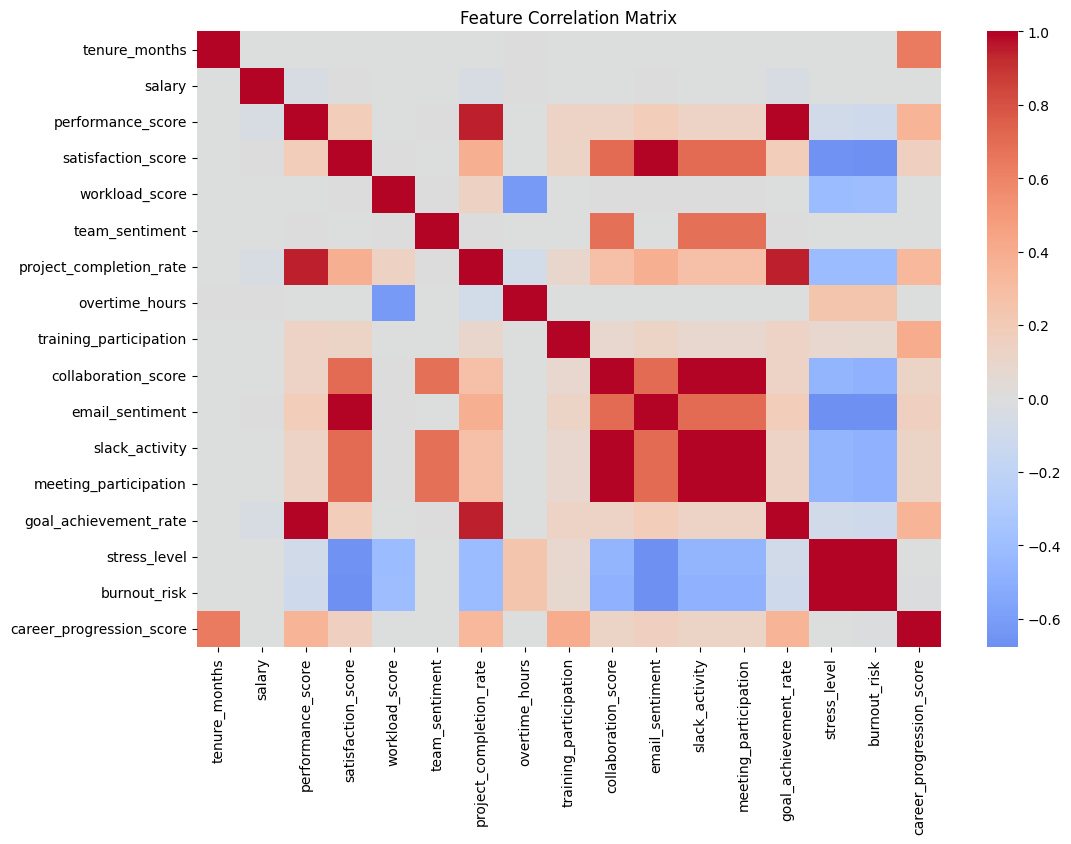

In [9]:
corr = df[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix")
plt.show()

### Correlation findings
- 'meeting_participation', 'slack_activity', and 'collaboration_score' are all closely linked and clustered
- 'project_completion_rate', 'performance_score' and 'goal_achievement_rate' are closely linked and clustered
- 'stress_level' and 'burnout_risk' are closely linked and clustered
- 'satisfaction_score' and 'email_sentiment' are both strongly negatively correlated with 'stress_level' and 'burnout_risk', showing the links between low work satisfaction and negative email sentiment with high work stress and burnout risk.
- Interestingly, 'salary' and 'tenure_months' don't show any strong corrleation either way with other factors, suggesting that higher saleries or length in a job doesn't have an impact on job satisfaction, stress or burnout risk. 

In [10]:
# Check differences in numeric columns between those who left the company and those who remained. 
df.groupby('left_company')[numeric_cols].mean().T

left_company,False,True
tenure_months,70.257273,70.154678
salary,84610.789767,84625.646710
performance_score,0.694103,0.686206
satisfaction_score,0.602417,0.531451
workload_score,0.604970,0.588395
team_sentiment,0.668211,0.667147
project_completion_rate,0.601265,0.580845
overtime_hours,3.026807,3.349441
training_participation,0.279335,0.279187
collaboration_score,0.483977,0.449782


In [11]:
# Elucidate the difference
summary = df.groupby('left_company')[numeric_cols].mean().T
summary['difference (left - stayed)'] = summary[True] - summary[False]
summary.sort_values('difference (left - stayed)', ascending=False)

left_company,False,True,difference (left - stayed)
salary,84610.789767,84625.646710,14.856943
overtime_hours,3.026807,3.349441,0.322635
burnout_risk,0.710921,0.795825,0.084903
stress_level,0.770088,0.840597,0.070509
training_participation,0.279335,0.279187,-0.000148
team_sentiment,0.668211,0.667147,-0.001064
career_progression_score,0.841465,0.837911,-0.003553
goal_achievement_rate,0.694103,0.686206,-0.007898
performance_score,0.694103,0.686206,-0.007898
workload_score,0.604970,0.588395,-0.016575


In [12]:
# Due to different unit types (eg salary, 0-1 scales, months), standardising the difference between leavers and stayers.
means = df.groupby('left_company')[numeric_cols].mean().T
stds = df[numeric_cols].std()

means['std_diff'] = (means[True] - means[False]) / stds
means.sort_values('std_diff', ascending=False)


left_company,False,True,std_diff
burnout_risk,0.710921,0.795825,0.267988
stress_level,0.770088,0.840597,0.265369
overtime_hours,3.026807,3.349441,0.052941
salary,84610.789767,84625.646710,0.000313
training_participation,0.279335,0.279187,-0.000664
tenure_months,70.257273,70.154678,-0.002042
team_sentiment,0.668211,0.667147,-0.005992
career_progression_score,0.841465,0.837911,-0.019403
performance_score,0.694103,0.686206,-0.042885
goal_achievement_rate,0.694103,0.686206,-0.042885


Employees who left the company exhibited significantly higher stress and burnout risk, alongside lower satisfaction and engagement metrics (email sentiment, collaboration, meeting participation). Salary, tenure, and performance metrics showed minimal differences between leavers and stayers, suggesting turnover is primarily driven by wellbeing and engagement rather than compensation or capability.


In [13]:
persona_summary = (
    df
    .groupby('persona_name')
    .agg(
        left_rate=('left_company', 'mean'),   # % who left
        avg_stress=('stress_level', 'mean'),
        avg_satisfaction=('satisfaction_score', 'mean'),
        goal_achievement_rate=('goal_achievement_rate', 'mean'),
        tenure_months=('tenure_months', 'mean'),
        salary=('salary', 'mean')
    )
    .sort_values('left_rate', ascending=False)
)

persona_summary

,left_rate,avg_stress,avg_satisfaction,goal_achievement_rate,tenure_months,salary
persona_name,,,,,,
BurntOutStar,0.339206,1.000000,0.283061,0.540631,70.343921,83814.248139
StrugglingLearner,0.328973,0.954524,0.440924,0.369428,69.826810,92008.034913
ChangeResistor,0.310031,0.959904,0.501503,0.706207,69.281682,83715.947298
AmbitiousClimber,0.302186,0.888627,0.576450,0.840642,70.597045,84011.644847
OverachievingSprinter,0.299951,0.959934,0.647778,0.900534,70.054047,83890.481536
CorporateNavigator,0.289224,0.792035,0.594402,0.759586,71.082089,83801.357363
QuietAchiever,0.273336,0.694886,0.668025,0.822441,70.323416,84107.349324
NewEnthusiast,0.262368,0.722135,0.743896,0.615312,69.493862,83799.801984
9-to-5Clockwatcher,0.260927,0.627874,0.561555,0.649650,70.694035,83979.398937


- Looking at the data above, we can see that there are no meaningful links between `tenure_months`, `salary` and any of the persona names.
- Stress, satisfaction and goal achievement rate are all linked to the persona names.

## Machine Learning Modelling
- Logistic regression for binary classification model on with `left_company` as the target feature

In [14]:
# dropping target column and columns that either won't add to the model or have too high cardinality for OHE
drop_cols = [
    'employee_id', 'left_company', 'turnover_reason',
    'risk_factors_summary', 'turnover_probability_generated', 'recent_feedback',
    'role_complexity_score', 'technical_skills', 'soft_skills'
]
X = df.drop(columns=drop_cols)
y = df['left_company']

In [15]:
X.head()

,role,job_level,department,tenure_months,salary,performance_score,satisfaction_score,workload_score,team_sentiment,project_completion_rate,...,training_participation,collaboration_score,email_sentiment,slack_activity,meeting_participation,goal_achievement_rate,stress_level,burnout_risk,persona_name,career_progression_score
0,Manager,Manager,Operations,76,73344,0.597337,0.564479,0.600587,0.671515,0.503239,...,0.426104,0.500839,0.586170,0.500839,0.500839,0.597337,0.873155,0.815900,QuietAchiever,0.915335
1,Genius,Mid,Sales,1,75100,0.668374,0.439555,0.217266,0.760264,0.534699,...,0.491142,0.469897,0.454386,0.469897,0.469897,0.668374,1.000000,1.000000,CorporateNavigator,0.678354
2,Unknown/Anonymous,Mid,Finance,1,91841,0.851203,0.617407,0.661551,0.796455,0.731371,...,0.354473,0.596024,0.640494,0.596024,0.596024,0.851203,0.747955,0.646864,CorporateNavigator,0.769768
3,Applications Developer,Mid,Bakery,59,96210,0.729163,0.723819,0.579709,0.836213,0.647522,...,0.326974,0.680088,0.733280,0.680088,0.680088,0.729163,0.679041,0.559556,SocialCatalyst,0.890415
4,Staff,Mid,Operations,84,149530,0.681677,0.885281,0.698757,0.623518,0.697522,...,0.043346,0.563349,0.862144,0.563349,0.563349,0.681677,0.239099,0.116914,9-to-5Clockwatcher,0.730838


In [16]:
# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

In [17]:
# Split into training and test sets
# Use stratify to preserve left/stayed balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work 

In [19]:
# Predict class labels (0 = stayed, 1 = left)
y_pred = pipe.predict(X_test)

In [20]:
# Evaluate the model's performance

# Accuracy is the proportion of correct predictions (both stayers and leavers)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print a detailed classification report
# Includes precision, recall, F1-score for each class
# - precision: proportion of predicted positives that are actually positive
# - recall: proportion of actual positives correctly predicted
# - F1-score: harmonic mean of precision and recall
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix
# Shows how many predictions fall into each category:
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]
# This is especially useful for imbalanced datasets like attrition
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.71285

Classification report:
               precision    recall  f1-score   support

       False       0.71      1.00      0.83     14264
        True       0.40      0.00      0.00      5736

    accuracy                           0.71     20000
   macro avg       0.56      0.50      0.42     20000
weighted avg       0.62      0.71      0.59     20000


Confusion matrix:
 [[14243    21]
 [ 5722    14]]


- The model is not working well, it's not predicting many leavers.

In [21]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work 

In [22]:
# Evaluate the model's performance

# Accuracy is the proportion of correct predictions (both stayers and leavers)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print a detailed classification report
# Includes precision, recall, F1-score for each class
# - precision: proportion of predicted positives that are actually positive
# - recall: proportion of actual positives correctly predicted
# - F1-score: harmonic mean of precision and recall
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix
# Shows how many predictions fall into each category:
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]
# This is especially useful for imbalanced datasets like attrition
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.71285

Classification report:
               precision    recall  f1-score   support

       False       0.71      1.00      0.83     14264
        True       0.40      0.00      0.00      5736

    accuracy                           0.71     20000
   macro avg       0.56      0.50      0.42     20000
weighted avg       0.62      0.71      0.59     20000


Confusion matrix:
 [[14243    21]
 [ 5722    14]]


- No improvement with the introduction of balanced classes
- Try another model - Random Forest Classifier

In [23]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  # again handles imbalance
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [24]:
# Predict class labels
y_pred_rf = rf.predict(X_test)

In [25]:
# Evaluate the model's performance

# Accuracy is the proportion of correct predictions (both stayers and leavers)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Print a detailed classification report
# Includes precision, recall, F1-score for each class
# - precision: proportion of predicted positives that are actually positive
# - recall: proportion of actual positives correctly predicted
# - F1-score: harmonic mean of precision and recall
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Print the confusion matrix
# Shows how many predictions fall into each category:
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]
# This is especially useful for imbalanced datasets like attrition
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.71285

Classification report:
               precision    recall  f1-score   support

       False       0.71      1.00      0.83     14264
        True       0.40      0.00      0.00      5736

    accuracy                           0.71     20000
   macro avg       0.56      0.50      0.42     20000
weighted avg       0.62      0.71      0.59     20000


Confusion matrix:
 [[14243    21]
 [ 5722    14]]


In [26]:
# Use a shallow Decision tree to check whether there is a strong enough signal in the data
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=42)
tree.fit(X_train[['satisfaction_score', 'stress_level', 'burnout_risk']], y_train)
print(classification_report(y_test, tree.predict(X_test[['satisfaction_score', 'stress_level', 'burnout_risk']])))

              precision    recall  f1-score   support

       False       0.77      0.44      0.56     14264
        True       0.33      0.68      0.44      5736

    accuracy                           0.51     20000
   macro avg       0.55      0.56      0.50     20000
weighted avg       0.65      0.51      0.53     20000



In [27]:
# Define high-signal features

high_signal_features = [
    'burnout_risk',
    'stress_level',
    'satisfaction_score',
    'email_sentiment',
    'workload_score',
    'project_completion_rate',
    'collaboration_score',
    'meeting_participation'
]

X = df[high_signal_features]  # keep only high-signal features
y = df['left_company']

In [28]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [29]:
# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,                   # limit depth to prevent overfitting
    class_weight='balanced_subsample',
    random_state=42
)

rf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [30]:
y_pred = rf.predict(X_test)

In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.53095

Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.49      0.60     14264
        True       0.33      0.63      0.44      5736

    accuracy                           0.53     20000
   macro avg       0.55      0.56      0.52     20000
weighted avg       0.64      0.53      0.55     20000


Confusion Matrix:
 [[6983 7281]
 [2100 3636]]


Feature importance:
                    feature  importance
1             stress_level    0.246795
0             burnout_risk    0.217792
2       satisfaction_score    0.163401
3          email_sentiment    0.144632
6      collaboration_score    0.069193
7    meeting_participation    0.065172
4           workload_score    0.047877
5  project_completion_rate    0.045138


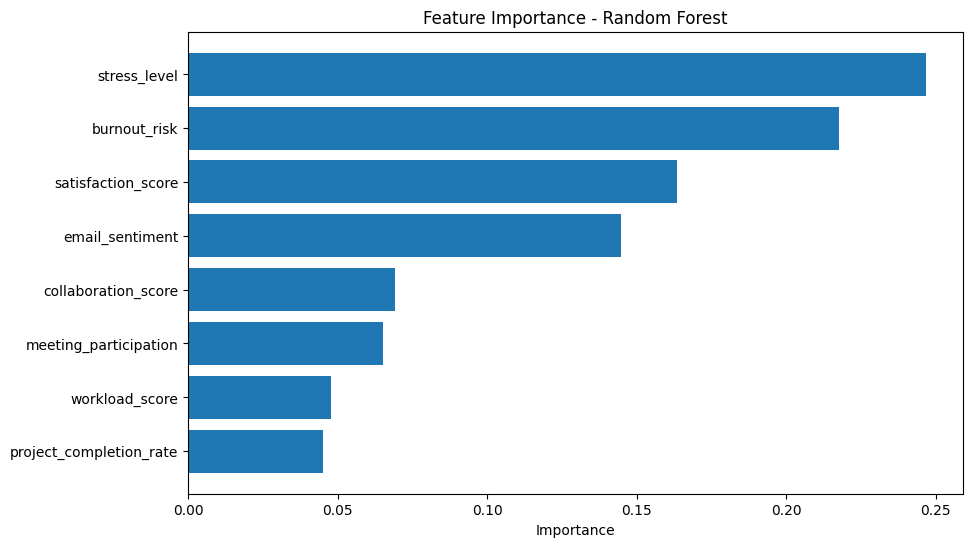

In [32]:
# Get feature importances from the trained Random Forest
feat_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Print the table
print("Feature importance:\n", feat_imp)

# Optional: plot top features
plt.figure(figsize=(10,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()  # largest on top
plt.xlabel("Importance")
plt.title("Feature Importance - Random Forest")
plt.show()

## Modelling Approaches and Iteration

Several models were tested to predict employee exits and burnout risk, balancing **performance** with **interpretability**.

**Logistic Regression**  
- Used as a baseline for simplicity and clear feature insights.  
- Struggled with class imbalance, resulting in low recall for exits.

**Decision Trees**  
- Captured non-linear relationships and were interpretable.  
- Early trees overfit the training data; pruning helped but performance remained inconsistent.

**Random Forests**  
- Reduced overfitting and improved predictive performance.  
- Feature importance analysis highlighted key drivers of exits and burnout.  
- Computational constraints on the large dataset required using the sampled data.

**Refinements Made**  
- Removed low-value or highly correlated features to improve generalisation.  
- Applied class weighting to address imbalance.  
- Random Forest was selected as the final model for analysis and visualisation, providing a strong balance of interpretability, accuracy, and efficiency.

**Key Takeaways**  
- Start with simple models to understand data patterns.  
- Monitor overfitting and adjust features or model complexity.  
- Document model iterations to guide reproducibility and reflection.


